# Tutoriel de résolution d'un problème de machine learning : clustering de différents types de fleurs sans informations préalables

## Problématique étudiée

L'objectif de ce cas est de trouver des groupes de fleurs, sans information préalable sur le type de fleur disponible avec le dataset Iris.

Il s'agit donc d'un cas de **machine learning non supervisé**, et plus spécifiquement d'un cas de **clustering**.

Ce notebook va vous guider à travers ce cas concret de clustering, et va utiliser un modèle particulier de machine learning pour réaliser cette tâche : le **K-Means clustering**. Les parties suivantes sont dédiées à l'implémentation de ce modèle grâce à l'utilisation de la librairie scikit-learn.

## Code

### Importation des différentes librairies 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from time import time
from sklearn import datasets, metrics
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


### Importation du dataset 

La première étape est d'importer le dataset et de voir de quoi il est constitué. Ici on importe le dataset Iris.

In [2]:
# Import the iris dataset
iris = datasets.load_iris()
iris.DESCR


'.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ============== ==== =

On voit grâce à la description détaillée qu'il s'agit d'un dataset qui classe les fleurs dans des types (targets) en fonction de la taille de leurs sépales et pétales (features). 

Il existe 3 types de fleurs (target) : setosa, versicolor, virginica avec 50 fleurs dans chaque types.
On a 4 features numériques pour chaque fleur : sepal length (cm), sepal width (cm), petal length (cm), petal width (cm).

Nous sommes donc en possession de 150 lignes de 4 colonnes.
Ici nous allons seulement utiliser les features car nous allons faire du machine learning non supervisé, c'est à dire que les datas n'ont pas de labels.

## Méthode K means

On commence par définir les données d'entrée X, on n'utilisera pas les données y car c'est un cas de machine learning non supervisé.

In [3]:
data, labels = load_iris(return_X_y=True)


In [4]:
X = data


Les données vont être regroupées par le modèle en cluster, on peut spécifier le nombre de clusters dans les paramètres du modèle. Avec la méthode des coudes (Elbow methode), nous allons définir le nombre de cluster optimal pour nos données.

Text(0, 0.5, 'Cout du modele (Inertia)')

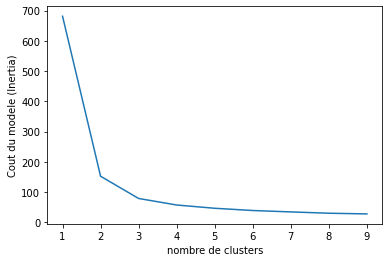

In [5]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    model = KMeans(n_clusters=k).fit(X)
    inertia.append(model.inertia_)
plt.plot(K_range, inertia)
plt.xlabel("nombre de clusters")
plt.ylabel("Cout du modele (Inertia)")

Le nombre optimal de clusters est le point après lequel l'inertie commence à diminuer de manière linéaire. Ainsi, pour les données de ce dataset ce nombre (n_clusters) est égal à 3. Ce qui est bien en corrélation avec les informations que nous avons sur le dataset : nous avons les données de 3 variétées d'iris setosa, versicolor et virginica.

Puis nous choisissons le modèle à mettre en place (Kmeans), nous l'apprenons, et nous affichons le résultat.

<function ndarray.sort>

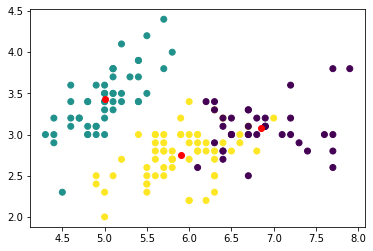

In [14]:
model = KMeans(n_clusters=3, n_init=10)
model.fit(X)
model.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=model.predict(X))
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c="r")
model.inertia_

Sur la figure on peut voir les clusters que le modèle a crée avec les points de différentes couleurs, et les centroïdes de chaque cluster sont en rouge. Le score d'inertie (la somme des distances au carré des échantillons à leur cluster centroïde le plus proche) est de 78.85.

In [51]:
type_de_fleurs = model.predict(X)
np.sort(type_de_fleurs)
x = type_de_fleurs
unique, counts = np.unique(x, return_counts=True)
x_count = np.asarray((unique, counts)).T
print(
    "Le cluster 0 contient {} fleurs, le cluster 1 contient {} fleurs et le cluster 2 contient {} fleurs".format(
        x_count[0][1], x_count[1][1], x_count[2][1]
    )
)

Le cluster 0 contient 38 fleurs, le cluster 1 contient 50 fleurs et le cluster 2 contient 62 fleurs


On peut voir que le clustering n'est pas parfait, car grâce à la description nous savons que chaque type de fleurs contient 50 fleurs. 

# Test de différents modèles

Dans cette partie, nous comparons les différentes stratégies d'initialisation de K-means en termes de temps d'exécution et de qualité des résultats.

### Définir notre benchmark d'évaluation

Nous allons d'abord définir notre benchmark d'évaluation. 
Au cours de ce benchmark, nous avons l'intention de comparer différentes méthodes d'initialisation pour KMeans. 

Notre benchmark va :

- créer un pipeline qui mettra à l'échelle les données en utilisant un StandardScaler ;

- entraîner et chronométrer l'adaptation du pipeline ;

- mesurer la performance du clustering obtenu via différentes métriques.

In [7]:
(n_samples, n_features), n_fleur_type = data.shape, np.unique(labels).size


def bench_k_means(kmeans, name, data, labels):

    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Exécuter le benchmark

Nous allons comparer trois approches :

- une initialisation utilisant kmeans++. Cette méthode est stochastique et nous allons exécuter l'initialisation 4 fois ;

- une initialisation aléatoire. Cette méthode est également stochastique et nous allons exécuter l'initialisation 4 fois ;

- une initialisation basée sur une projection PCA. En effet, nous utiliserons les composantes de l'ACP pour initialiser KMeans. Cette méthode est déterministe et une seule initialisation suffit.

*stochastique* = qui se produit par l'effet du hasard.


In [8]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_fleur_type,
                n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_fleur_type,
                n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_fleur_type).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_fleur_type, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")


__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.130s	140	0.659	0.660	0.659	0.620	0.655	0.506
random   	0.132s	140	0.659	0.660	0.659	0.620	0.655	0.506
PCA-based	0.035s	191	0.535	0.657	0.590	0.433	0.584	0.519
__________________________________________________________________________________


**homo (homogeneity score):** chaque cluster ne contient que des membres d'une seule classe. Valeur de 0 à 1, doit se rapprocher de 1.

**compl (completeness score):** tous les membres d'une classe donnée sont assignés au même cluster. Valeur de 0 à 1, doit se rapprocher de 1.

**V-means (V measure):** est la moyenne harmonique entre l'homogénéité et la complétude. Valeur entre 0,0 et 1,0. 1.0 correspond à un étiquetage parfait.

**ARI (adjusted Rand index):** Score de similarité entre -1,0 et 1,0. Les étiquetages aléatoires ont un ARI proche de 0,0. 1.0 correspond à une correspondance parfaite.

**AMI (adjusted mutual information):** L'AMI renvoie une valeur de 1 lorsque les deux partitions sont identiques (c'est-à-dire parfaitement appariées). Les partitions aléatoires (étiquetages indépendants) ont un AMI attendu autour de 0 en moyenne et peuvent donc être négatives.

**Silhouette:** Le coefficient de silhouette est calculé en utilisant la distance intra-groupe moyenne (a) et la distance la plus proche (b) pour chaque échantillon. Cette fonction renvoie le Coefficient de Silhouette moyen sur tous les échantillons. La meilleure valeur est 1 et la pire valeur est -1. Les valeurs proches de 0 indiquent des clusters qui se chevauchent. Les valeurs négatives indiquent généralement qu'un échantillon a été assigné au mauvais cluster, car un cluster différent est plus similaire.

Les résultats nous montrent que le modèle le plus rapide est le PCA mais qu'il à des metrics plus basses (homo, compl, v-meas, ARI, AMI), les modèles Kmeans avec une initialisation Kmeans++ et random ont exactement les mêmes metrics entre elles.

###  Visualiser les résultats sur des données réduites par l'ACP

L'ACP permet de projeter les données de l'espace original à 64 dimensions dans un espace de dimension inférieure. Par la suite, nous pouvons utiliser l'ACP pour projeter les données dans un espace à 2 dimensions et tracer les données et les clusters dans ce nouvel espace.

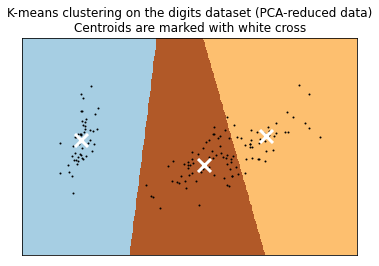

In [9]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_fleur_type, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


Sur ce graphique nous pouvons visualiser les trois clusters séparés par les couleurs avec leurs centroïdes simbolisés d'une croix blanche.

### C'est la fin de ce tuto sur le modèle des K-means. Vous pouvez tester ce modèle avec d'autres paramètres (init, n_cluster, n_init...) ou d'autres données.